ESN model is imported from the link below and it is further adapted for a Time Series Regression Task

In [ ]:
!git clone https://github.com/FilippoMB/Time-series-classification-and-clustering-with-Reservoir-Computing MTS_reservoir_model

import sys
sys.path.append('/content/MTS_reservoir_model/code')

from MTS_reservoir_model.code.reservoir import Reservoir


Cloning into 'MTS_reservoir_model'...
remote: Enumerating objects: 173, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 173 (delta 0), reused 1 (delta 0), pack-reused 169
Receiving objects: 100% (173/173), 1.89 MiB | 27.72 MiB/s, done.
Resolving deltas: 100% (90/90), done.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from scipy.spatial.distance import pdist, cdist, squareform
import copy
import random
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# EDA

### Boxplot for outliers

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


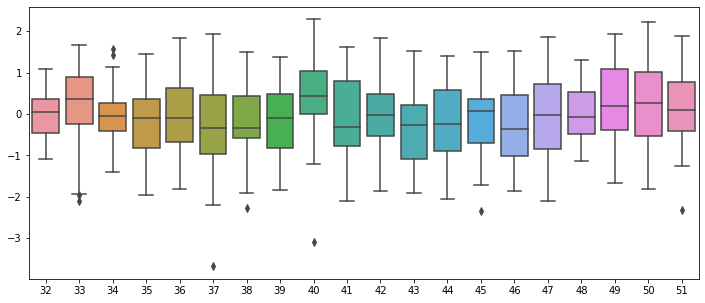

In [ ]:
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt

n = 480
ts = pd.Series(np.random.randn(n), index=pd.date_range(start="2014-02-01", periods=n, freq="H"))

fig, ax = plt.subplots(figsize=(12,5))
seaborn.boxplot(ts.index.dayofyear, ts, ax=ax)

### Load the data and plot the target for every of the 5 companies

In [ ]:
stock_data = pd.read_excel(r'/content/drive/MyDrive/master/lseg/DataSet_Target Portfolio - exported on 19th of April.xlsx', 'GS')
stock_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-04-11,116.370003,117.019997,115.559998,115.930000,98.615738,4177500
1,2012-04-12,116.570000,120.410004,116.000000,120.389999,102.409637,5514600
2,2012-04-13,119.989998,120.089996,114.889999,115.089996,97.901184,6368200
3,2012-04-16,117.120003,118.410004,114.959999,117.730003,100.146912,7137600
4,2012-04-17,119.370003,119.769997,116.239998,116.860001,99.406837,12894400
...,...,...,...,...,...,...,...
2517,2022-04-11,320.609985,328.899994,319.029999,320.760010,320.760010,2747700
2518,2022-04-12,321.679993,327.119995,318.010010,319.779999,319.779999,2365200
2519,2022-04-13,315.799988,322.630005,314.720001,321.970001,321.970001,3022900
2520,2022-04-14,328.470001,333.029999,319.029999,321.640015,321.640015,5451000


Stock symbols:  ['GS', 'C', 'WFC', 'BAC', 'JPM']
Shape of the Unprocessed data:  (5, 2522, 6)


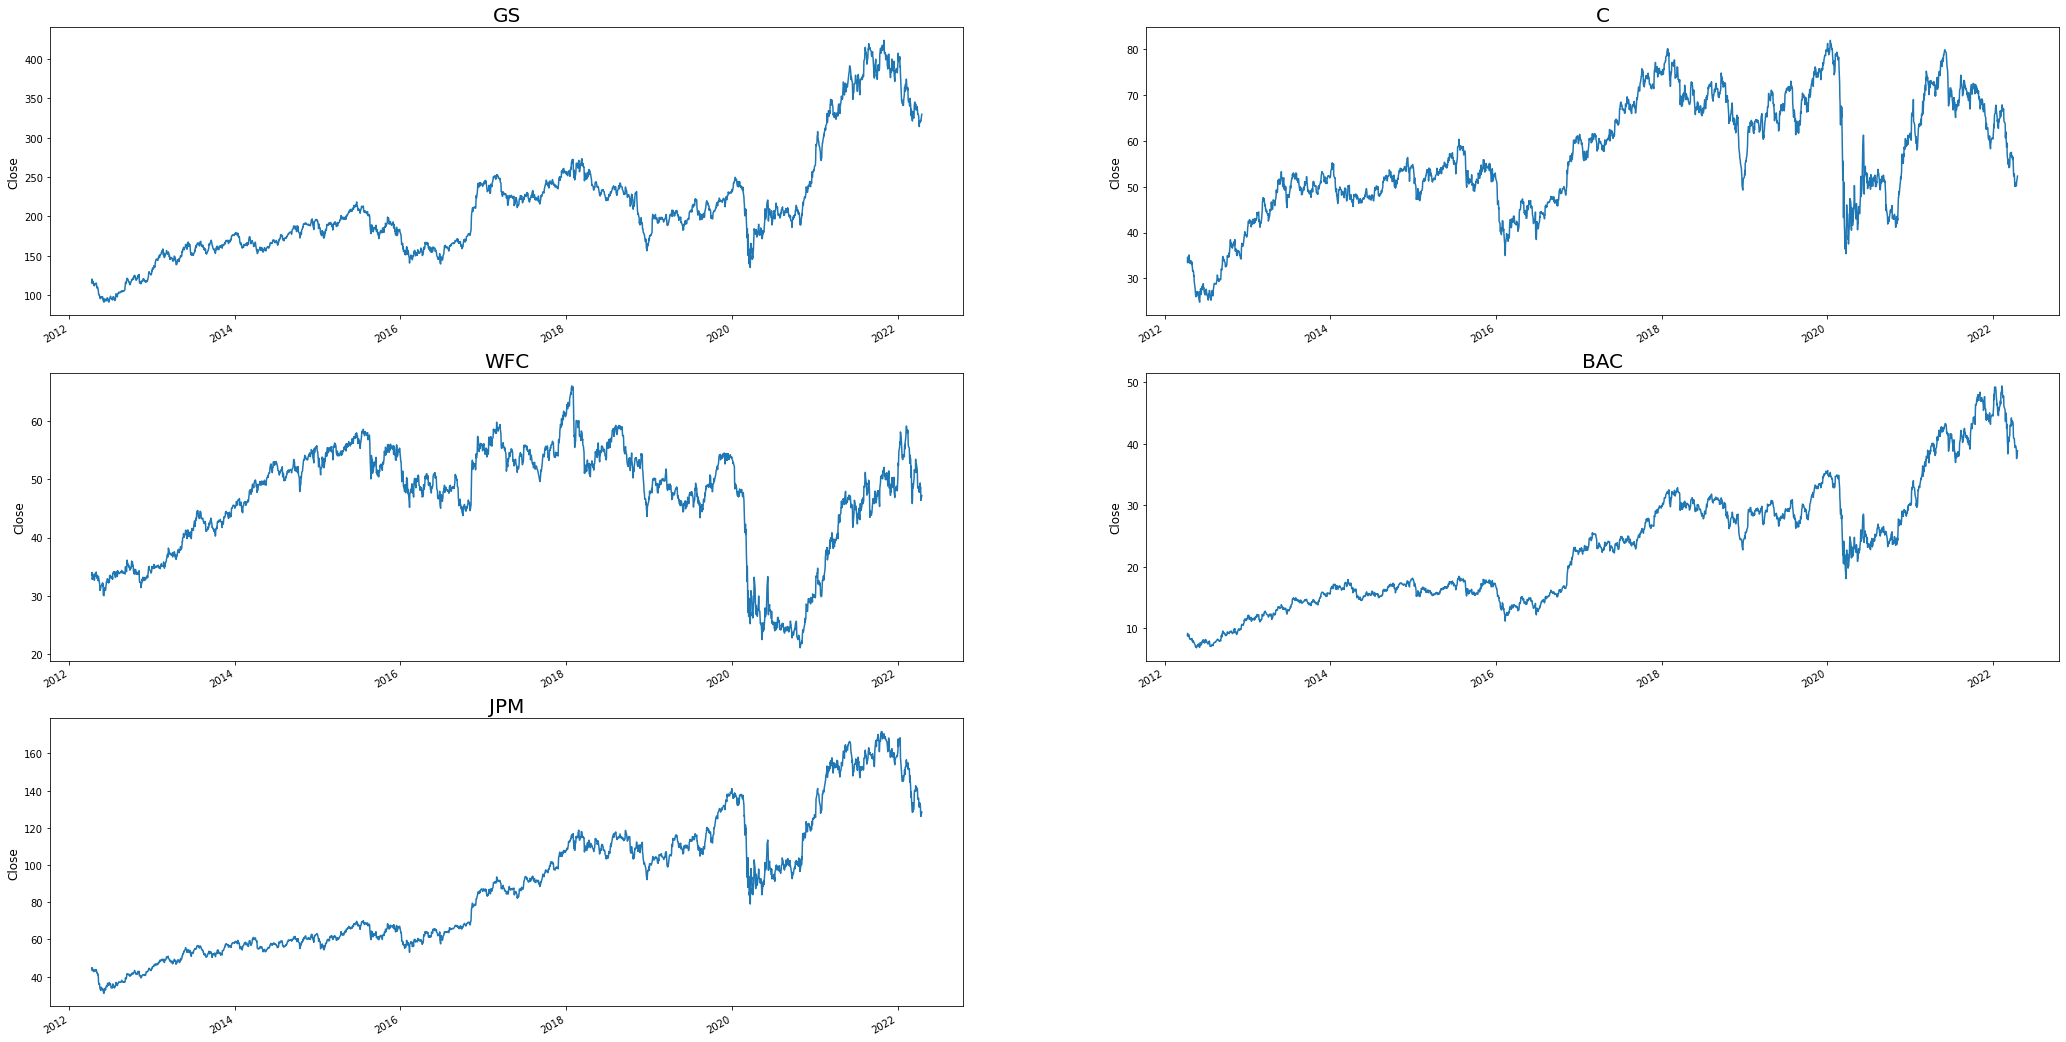

In [ ]:
portofolio = pd.ExcelFile(r'/content/drive/MyDrive/master/lseg/DataSet_Target Portfolio - exported on 19th of April.xlsx').sheet_names

historical_data = []                                                            #list with all the unprocessed data from every company in the portofolio. Every element is a dataframe
historical_data.clear()
all_data=[]
plt.figure(figsize=(36, 20))
all_data.clear()
for idx,company in enumerate(portofolio):
  plt.subplot(3,2,idx+1)
  
  stock_data = pd.read_excel(r'/content/drive/MyDrive/master/lseg/DataSet_Target Portfolio - exported on 19th of April.xlsx', company)
  stock_data.set_index("Date",inplace=True)
  date_stock_data = copy.copy(stock_data)
  all_data.append(date_stock_data)
  stock_data['Close'].plot()
  plt.ylabel('Close',fontsize=12)
  plt.xlabel(None,fontsize=12)
  plt.title(f"{company}",fontsize=20)
  stock_data.reset_index(inplace=True)
  stock_data.drop("Date",axis=1, inplace=True)
  historical_data.append(stock_data)

print("Stock symbols: ",portofolio)
print("Shape of the Unprocessed data: ",np.array(historical_data).shape)

### Preprocessing Functions

In [ ]:
def lag_features(features, window_size):                                        # X(t) will have as predictors the features from the previous window_size timestamps X(t-1),...,x(t-window_size)
  X = []
  for i in range(len(features)-window_size):
    row = [a for a in features[i:i+window_size]]
    X.append(row)
  return np.array(X)

### Echo State Network

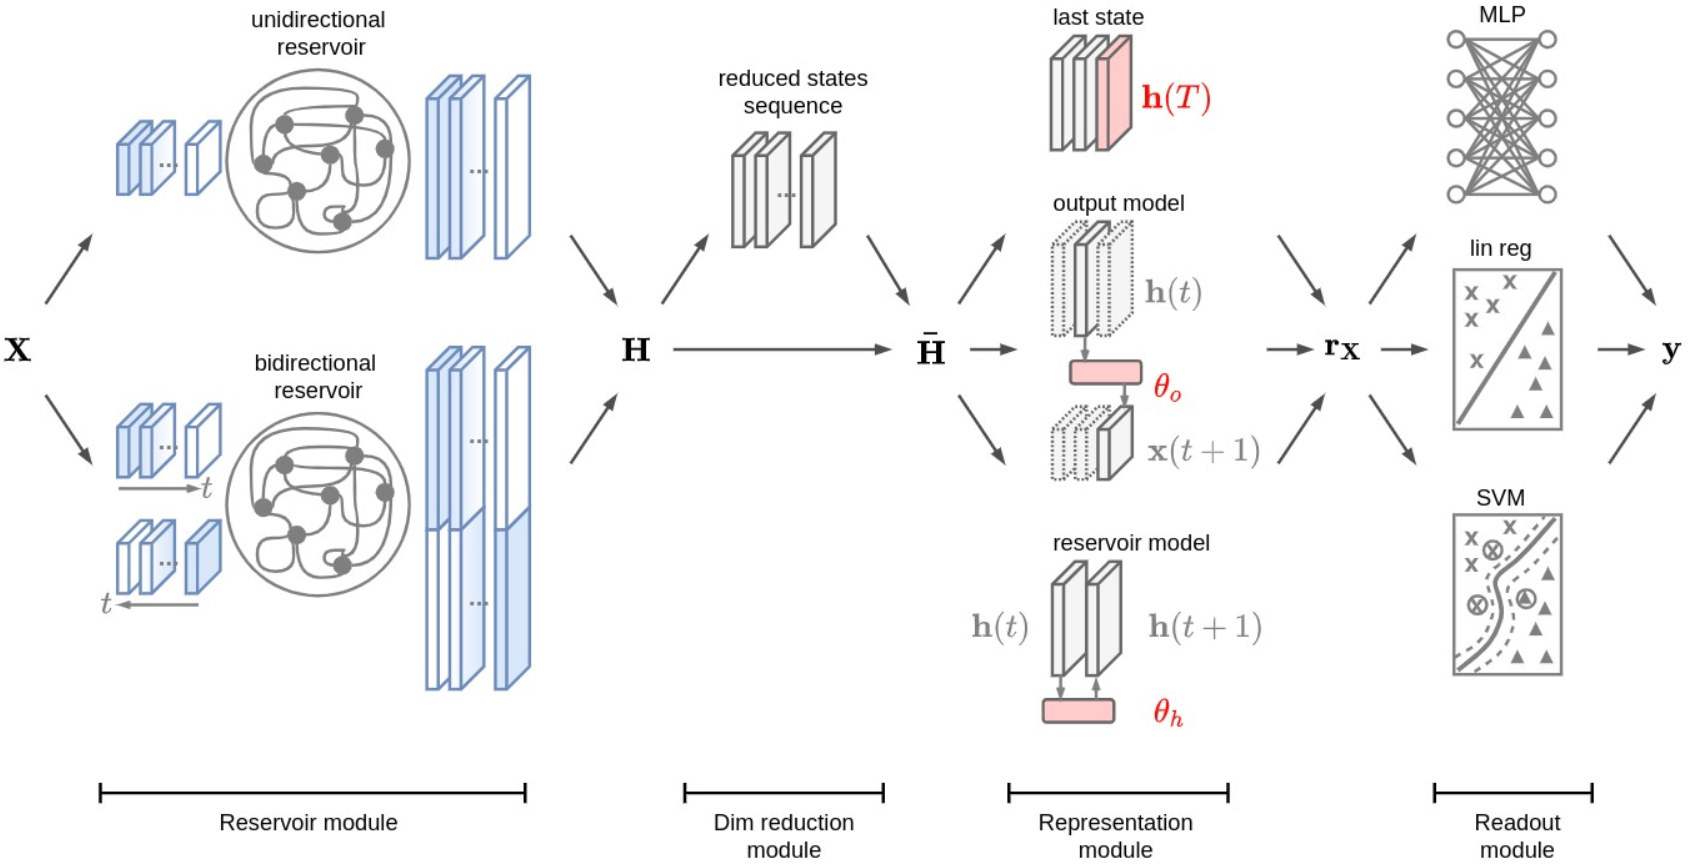

Reimplemented the RC_model in order to:

*   support GridSearchCV via scikit
*   analyze the explained variances of different choices of principal components
*   have a fixed seed for the random generators
*   perform Time Series forecasting instead of Time Series Classification




  
The original implementation can be found at the following link:
https://github.com/FilippoMB/Time-series-classification-and-clustering-with-Reservoir-Computing/blob/master/code/modules.py



In [ ]:
import numpy as np
import time
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neural_network import MLPRegressor
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.base import BaseEstimator,ClassifierMixin
from sklearn.utils.multiclass import check_classification_targets
from IPython.display import display

class RC_model_enhanced(BaseEstimator, ClassifierMixin):

    def __init__(self,
              # reservoir attirbutes
              _reservoir=None,                                                  # object of class Reservoir_enhanced
              n_internal_units=None,                                            # number of processing units in the reservoir
              spectral_radius=None,                                             # largest eigenvalue of the reservoir matrix of connection weights
              leak=None,                                                        # amount of leakage in the reservoir state update
              connectivity=None,                                                # percentage of nonzero connection weights
              input_scaling=None,                                               # scaling of the input connection weights
              noise_level=None,                                                 # deviation of the Gaussian noise injected in the state update
              circle=False,                                                     # Reservoir circle architecture (if True)
              random_seed = 11,                                                 # random seed to be used by numpy and scipy generators
              bidir=False,                                                      #use a bidirectional reservoir (True or false)
              n_drop=None,                                                      # number of reservoir transient states to drop

              # Dim reduction attributes
              dimred_method=None,                                               # procedure for reducing the number of features in the sequence of reservoir states;
                                                                                # possible options are: None (no dimensionality reduction), 'pca' or 'tenpca'
              n_dim=None,                                                       # number of resulting dimensions after the dimensionality reduction procedure

              # Representation attributes                                       
              mts_rep=None,                                                     # type of Multivariate Time Series representation. It can be 'last' (last state), 'output' (output model space),
                                                                                # or 'reservoir' (reservoir model space)
              _w_ridge_reservoir=None,                                          # regularization parameter of the ridge regression in the output model space
                                                                                # and reservoir model space representation; ignored if mts_rep == None
              
              # Readout attributes
              readout_type=None,                                                # type of readout used for classification. It can be 'lin' (ridge regression), 
                                                                                # 'mlp' (multiplayer perceptron)  or None.
                                                                                # If None, the input representations will be saved instead: this is useful for clustering and visualization.
              w_ridge=None,                                                     # regularization parameter of the ridge regression readout (only for readout_type=='lin') 
              mlp_layout=None,                                                  # mlp_layout = tuple with the sizes of MLP layers, e.g. (20, 10) defines a MLP with 2 layers 
                                                                                # of 20 and 10 units respectively. (only for readout_type=='mlp')
              num_epochs=None,                                                  # number of iterations during the optimization (only for readout_type=='mlp')
              w_l2=None,                                                        # weight of the L2 regularization (only for readout_type=='mlp')
              nonlinearity=None,                                                # type of activation function {'relu', 'tanh', 'logistic', 'identity'} (only for readout_type=='mlp')
              svm_gamma=1.0,                                                    # bandwith of the RBF kernel (only for readout_type=='svm')
              svm_C=1.0                                                         # regularization for SVM hyperplane (only for readout_type=='svm')
              ):

        # Parameters with trailing _ are not to be set inside the __init__ method.
        # All and only the public attributes set by fit have a trailing _. As a result the existence of parameters with trailing _ is used to check if the estimator has been fitted.
        

        #In order to make this class Sklearn compliant, attributes which start with _ are changed inside the predict() method.

        self.n_drop=n_drop
        self.bidir=bidir
        self.dimred_method=dimred_method
        self.mts_rep=mts_rep
        self.readout_type=readout_type
        self.circle = circle
        self.n_internal_units = n_internal_units
        self.spectral_radius=spectral_radius
        self.leak=leak      
        self.connectivity=connectivity
        self.input_scaling=input_scaling
        self.noise_level=noise_level
        self.n_dim =n_dim
        self._w_ridge_reservoir = _w_ridge_reservoir
        self.mlp_layout =mlp_layout
        self.num_epochs =num_epochs
        self.w_l2 = w_l2
        self.nonlinearity = nonlinearity
        self.svm_C = svm_C
        self.svm_gamma=svm_gamma
        self.w_ridge = w_ridge
        self._reservoir = _reservoir
        self.random_seed = random_seed

    def fit(self, X, Y=None):
        ########################################################################
        # Initialize reservoir
        if self._reservoir is None:
            self._reservoir = Reservoir_enhanced(n_internal_units=self.n_internal_units,        
                                  spectral_radius=self.spectral_radius,
                                  leak=self.leak,
                                  connectivity=self.connectivity,
                                  input_scaling=self.input_scaling,
                                  noise_level=self.noise_level,
                                  circle=self.circle,
                                  random_seed=self.random_seed)
            
                
        # Initialize dimensionality reduction method
        if self.dimred_method is not None:
            if self.dimred_method.lower() == 'pca':
                self._dim_red = PCA(n_components=self.n_dim)            
            elif self.dimred_method.lower() == 'tenpca':
                self._dim_red = tensorPCA(n_components=self.n_dim)
            else:
                raise RuntimeError('Invalid dimred method ID')
                
        # Initialize ridge regression model
        if self.mts_rep=='output' or self.mts_rep=='reservoir':
            self._ridge_reservoir = Ridge(alpha=self._w_ridge_reservoir, fit_intercept=True)
        # Initialize readout type            
        if self.readout_type is not None:
            
            if self.readout_type == 'lin': # Ridge regression
                self._readout = Ridge(alpha=self.w_ridge)             
            elif self.readout_type == 'mlp': # MLP (deep readout)  
                # pass
                self._readout = MLPRegressor(
                    hidden_layer_sizes=self.mlp_layout, 
                    activation=self.nonlinearity,
                    solve = 'adam',
                    alpha=self.w_l2,
                    batch_size=32,
                    shuffle = False,
                    learning_rate='adaptive',   # 'constant' or 'adaptive'
                    learning_rate_init=0.001, 
                    max_iter=self.num_epochs, 
                    early_stopping=False, # if True, set validation_fraction > 0
                    validation_fraction=0.0 # used for early stopping
                    )
            else:
                raise RuntimeError('Invalid readout type')  
        ########################################################################
        time_start = time.time()
        
        # ============ Compute reservoir states ============ 
        res_states = self._reservoir.get_states(X, n_drop=self.n_drop, bidir=self.bidir)
        
        # ============ Dimensionality reduction of the reservoir states ============  
        pca_list = list()
        pca_list.clear()
        if self.dimred_method.lower() == 'pca':

            # matricize
            N_samples = res_states.shape[0]
            res_states = res_states.reshape(-1, res_states.shape[2])

            '''for dim in range(int(0.7*self.n_dim) ,self.n_dim+1):
                print(f"Computing dimension {dim}")
                self._dim_red = PCA(n_components=dim)
                self._dim_red.fit(res_states)
                    
                pca_list.append(pd.Series({'n':dim, 'Model':self._dim_red, 'Explained Variance':str(round(self._dim_red.explained_variance_ratio_.sum()*100,2))+"%"}))'''
            self._dim_red.fit(res_states)
            red_states = self._dim_red.transform(res_states)

            # ..and put back in tensor form
            red_states = red_states.reshape(N_samples,-1,red_states.shape[1])
            #pca_df = pd.concat(pca_list, axis=1).T.set_index('n')
            #display(pca_df)
        elif self.dimred_method.lower() == 'tenpca':
            red_states = self._dim_red.fit_transform(res_states)       
        else: # Skip dimensionality reduction
            red_states = res_states

        # ============ Generate representation of the MTS ============
        coeff_tr = []
        biases_tr = []   
        # Output model space representation
        if self.mts_rep=='output':
            if self.bidir:
                X = np.concatenate((X,X[:, ::-1, :]),axis=2)                
                
            for i in range(X.shape[0]):
                self._ridge_reservoir.fit(red_states[i, 0:-1, :], X[i, self.n_drop+1:, :])
                coeff_tr.append(self._ridge_reservoir.coef_.ravel())
                biases_tr.append(self._ridge_reservoir.intercept_.ravel())
            input_repr = np.concatenate((np.vstack(coeff_tr), np.vstack(biases_tr)), axis=1)
            
        # Reservoir model space representation
        elif self.mts_rep=='reservoir':
            for i in range(X.shape[0]):
                self._ridge_reservoir.fit(red_states[i, 0:-1, :], red_states[i, 1:, :])
                coeff_tr.append(self._ridge_reservoir.coef_.ravel())
                biases_tr.append(self._ridge_reservoir.intercept_.ravel())
            input_repr = np.concatenate((np.vstack(coeff_tr), np.vstack(biases_tr)), axis=1)
        
        # Last state representation        
        elif self.mts_rep=='last':
            input_repr = red_states[:, -1, :]
            
        # Mean state representation        
        elif self.mts_rep=='mean':
            input_repr = np.mean(red_states, axis=1)
            
        else:
            raise RuntimeError('Invalid representation ID')            
            
        # ============ Apply readout ============
        print("The shape:",input_repr.shape)
        if self.readout_type == None: # Just store the input representations
            self._input_repr = input_repr
            
        elif self.readout_type == 'lin': # Ridge regression
            self._readout.fit(input_repr, Y)          
            
        elif self.readout_type == 'mlp': # MLP (deep readout)
            self._readout.fit(input_repr, Y)
                        
        return self

            
    def predict(self, Xte):
        # ============ Compute reservoir states ============
        res_states_te = self._reservoir.get_states(Xte, n_drop=self.n_drop, bidir=self.bidir) 
        
        # ============ Dimensionality reduction of the reservoir states ============ 
        if isinstance(self.dimred_method, str) and self.dimred_method.lower() == 'pca':
            # matricize
            N_samples_te = res_states_te.shape[0]
            res_states_te = res_states_te.reshape(-1, res_states_te.shape[2])

            # ..transform..
            red_states_te = self._dim_red.transform(res_states_te) 

            # ..and put back in tensor form
            red_states_te = red_states_te.reshape(N_samples_te,-1,red_states_te.shape[1])      

        elif isinstance(self.dimred_method, str) and self.dimred_method.lower() == 'tenpca':
            red_states_te = self._dim_red.transform(res_states_te)        

        else: # Skip dimensionality reduction
            red_states_te = res_states_te             
        
        # ============ Generate representation of the MTS ============
        coeff_te = []
        biases_te = []   
        
        # Output model space representation
        if self.mts_rep=='output':
            if self.bidir:
                Xte = np.concatenate((Xte,Xte[:, ::-1, :]),axis=2)  
            for i in range(Xte.shape[0]):
                self._ridge_reservoir.fit(red_states_te[i, 0:-1, :], Xte[i, self.n_drop+1:, :])
                coeff_te.append(self._ridge_reservoir.coef_.ravel())
                biases_te.append(self._ridge_reservoir.intercept_.ravel())
            input_repr_te = np.concatenate((np.vstack(coeff_te), np.vstack(biases_te)), axis=1)

        # Reservoir model space representation
        elif self.mts_rep=='reservoir':    
            for i in range(Xte.shape[0]):
                self._ridge_reservoir.fit(red_states_te[i, 0:-1, :], red_states_te[i, 1:, :])
                coeff_te.append(self._ridge_reservoir.coef_.ravel())
                biases_te.append(self._ridge_reservoir.intercept_.ravel())
            input_repr_te = np.concatenate((np.vstack(coeff_te), np.vstack(biases_te)), axis=1)

        # Last state representation        
        elif self.mts_rep=='last':
            input_repr_te = red_states_te[:, -1, :]
            
        # Mean state representation        
        elif self.mts_rep=='mean':
            input_repr_te = np.mean(red_states_te, axis=1)
        else:
            raise RuntimeError('Invalid representation ID')

        # ============ Apply readout ============
        if self.readout_type == 'lin': # Ridge regression        
            pred_values = self._readout.predict(input_repr_te)

        elif self.readout_type == 'mlp': # MLP (deep readout)
            pred_values = self._readout.predict(input_repr_te)
            pred_values = np.argmax(pred_class, axis=1)
        return pred_values

In [ ]:
pca_list = list()
pca_list.clear()

### Reservoir

Reimplemented the Reservoir class in order to support random weight generation with a fixed seed.

The original implementation can be found at the following link:
https://github.com/FilippoMB/Time-series-classification-and-clustering-with-Reservoir-Computing/blob/master/code/reservoir.py

In [ ]:
from scipy import sparse

class Reservoir_enhanced(Reservoir):
  def __init__(self, n_internal_units=100, spectral_radius=0.99, leak=None,
                 connectivity=0.3, input_scaling=0.2, noise_level=0.01, circle=False, random_seed = 100):
        
        # Initialize attributes
        self._n_internal_units = n_internal_units
        self._input_scaling = input_scaling
        self._noise_level = noise_level
        self._leak = leak
        self._random_seed = random_seed

        # Input weights depend on input size: they are set when data is provided
        self._input_weights = None

        # Generate internal weights
        if circle:
            self._internal_weights = self._initialize_internal_weights_Circ(
                    n_internal_units,
                    spectral_radius)
        else:
            self._internal_weights = self._initialize_internal_weights(
                n_internal_units,
                connectivity,
                spectral_radius)
  
  def _initialize_internal_weights(self, n_internal_units,
                                     connectivity, spectral_radius):

        # Generate sparse, uniformly distributed weights.
        internal_weights = sparse.rand(n_internal_units,
                                       n_internal_units,
                                       density=connectivity,random_state=self._random_seed).todense()

        # Ensure that the nonzero values are uniformly distributed in [-0.5, 0.5]
        internal_weights[np.where(internal_weights > 0)] -= 0.5
        
        # Adjust the spectral radius.
        E, _ = np.linalg.eig(internal_weights)
        e_max = np.max(np.abs(E))
        internal_weights /= np.abs(e_max)/spectral_radius       

        return internal_weights

  def _compute_state_matrix(self, X, n_drop=0):
        N, T, _ = X.shape
        np.random.seed(self._random_seed)
        previous_state = np.zeros((N, self._n_internal_units), dtype=float)

        # Storage
        state_matrix = np.empty((N, T - n_drop, self._n_internal_units), dtype=float)

        for t in range(T):
            current_input = X[:, t, :]

            # Calculate state
            state_before_tanh = self._internal_weights.dot(previous_state.T) + self._input_weights.dot(current_input.T)

            # Add noise
            state_before_tanh += np.random.rand(self._n_internal_units, N)*self._noise_level

            # Apply nonlinearity and leakage (optional)
            if self._leak is None:
                previous_state = np.tanh(state_before_tanh).T
            else:
                previous_state = (1.0 - self._leak)*previous_state + np.tanh(state_before_tanh).T

            # Store everything after the dropout period
            if (t > n_drop - 1):
                state_matrix[:, t - n_drop, :] = previous_state

        return state_matrix


  def get_states(self, X, n_drop=0, bidir=True):
        N, T, V = X.shape
        np.random.seed(self._random_seed)
        if self._input_weights is None:
            self._input_weights = (2.0*np.random.binomial(1, 0.5 , [self._n_internal_units, V]) - 1.0)*self._input_scaling

        # compute sequence of reservoir states
        states = self._compute_state_matrix(X, n_drop)
    
        # reservoir states on time reversed input
        if bidir is True:
            X_r = X[:, ::-1, :]
            states_r = self._compute_state_matrix(X_r, n_drop)
            states = np.concatenate((states, states_r), axis=2)

        return states

### Model instantiation

In [ ]:
clf.

In [ ]:
clf = RC_model_enhanced(# reservoir
                    _reservoir=None,         #precomputed reservoir (oject of class 'Reservoir');
                                            #if None, the following structural hyperparameters must be specified
                    n_internal_units=400,
                    spectral_radius=0.89,
                    leak=0.2,              #amount of leakage in the reservoir state update
                    connectivity=0.1,       #percentage of nonzero connection weights
                    input_scaling=1, #tbd
                    noise_level=0.01,
                    n_drop=0,  #tbd
                    random_seed = 59,
                    circle=False,
                    bidir=False,  #tbd
                    # dim red
                    dimred_method='pca',    #'pca',   #'pca' or 'tenpca'
                    n_dim=67,                # tbd # number of resulting dimensions after the dimensionality reduction procedure

                    # representation
                    mts_rep='output',         # type of MTS representation.'last' (last state), 'output' (output model space),
                                            #or 'reservoir' (reservoir model space)
                    _w_ridge_reservoir=.01, #regularization parameter of the ridge regression in the output model space
                                            #and reservoir model space representation; ignored if mts_rep == None
                               
                    # readout
                    readout_type='lin',               
                    w_ridge=.1,              
                    mlp_layout=(200, 100),
                    num_epochs=500,
                    w_l2=0.001,            #tbd #weight of the L2 regularization (only for readout_type=='mlp')
                    nonlinearity='relu', 
                    svm_gamma=1.0,        #only for svm readout
                    svm_C=1.0,            #only for svm readout
                    )

### Fitting the model

### Lag feature space, training and testing

The following code block creates a Lag Feature Space for every data point.
Let t be the first day to be forecasted. These loops create a feature space for day t, predict the Close price and then, the predicted values are reused for the Lag Feature Space generation. Because the Reservoir is bidirectional the value forecasted for day t changes after every prediction of t+k, with k>0.



Every feature becomes a predicted target in order to be integrated in the train set of day t.

In [ ]:
from sklearn.preprocessing import StandardScaler

ftr_names = historical_data[0].columns
print(f"Initial features: {ftr_names}")
lagged_window=20                                                               # number of lagged values to be taken into consideration
prediction_period = 5                                                           # number of days to predict
all_predictions = [] 
all_predictions.clear()                                          
new_entry = []                                                                  # Close Price List from day t to be appended to the train set and further refeeded to the classifier
for co_idx,company_stock in enumerate(historical_data):
    prediction_list = np.array([])                                              # this list will store the Close prediction for every company
    #yt = company_stock['Close'][-prediction_period:] 
    final_prediction = np.array([])                                             # this array will contain only the predictions from the last state of the reservoir
    for idx in range(prediction_period):                                        # iterate through every day to be forecasted
        print(f"Company {portofolio[co_idx]}, Day {idx+1}")
        new_entry.clear()

        for i,feature_name in enumerate(ftr_names):                             # iterate through the initial features

            #Split data into X and y
            print(f"    Processing feature ({feature_name})...")
            stock_temp = copy.copy(company_stock)
            y = stock_temp.pop(feature_name).to_numpy()
            X = copy.copy(stock_temp).to_numpy()

            #train and test split
            X_train = copy.copy(X)                        
            y_train = copy.copy(y)

            # append the last predicted value to the train set
            if prediction_list.size > 0:
              prediction_list = prediction_list.reshape(idx,len(ftr_names))
              configured_prediction_list = copy.copy(prediction_list)
              configured_prediction_list = np.delete(configured_prediction_list, i, 1)  #remove the target for this iteration
              X_train = np.vstack([X_train, np.array(configured_prediction_list)])
              y_train = np.append(y_train, prediction_list[-1][i])
            X_train_extended = copy.copy(X_train)                                       
            X_train_extended = np.vstack([X_train_extended, np.ones(X_train_extended.shape[1])])  #add a row of 1's to prepare the data for Lag Feature Generation

            X_test = X_train_extended[-(lagged_window+1+idx):]
            y_test = y[-(prediction_period-idx)]                                      
            
            #scaling and Lag Features    
            scaler = StandardScaler().fit(X_train)
            X_train_scaled = scaler.transform(X_train)
            X_train = lag_features(X_train_scaled, lagged_window)               # create new features using the previous days values. The window is equal with the variable lagged_window.
                                                                                # lagged_window can be seen as the number of time steps in each sample, before dropping some of the Reservoir states
            y_train = y_train[lagged_window:]                                   # ignore the first lagged_window targets, as it is not possible to create new features for them

            X_test_scaled = scaler.transform(X_test)          
            X_test = lag_features(X_test_scaled,lagged_window)

            print("        ",X_train.shape, y_train.shape, X_test.shape, y_test.shape)

            #fiting the model and predicting the the feature for the next day
            clf.fit(X_train[-400:], y_train[-400:])
            prediction = clf.predict(X_test)
            print(f"Predicted value for {feature_name} in the next day: {prediction}. Real value: {y_test}")
            new_entry.append(prediction[0].astype('float64'))
            if idx == prediction_period-1:
              final_prediction = np.append(final_prediction, prediction)

        print(f"Prediction for this company in day {idx}: {new_entry}")
        prediction_list = np.append(prediction_list, new_entry)
        print("\n")
    final_prediction = final_prediction.reshape(len(ftr_names),prediction_period) #get only the last day prediction
    all_predictions.append(final_prediction)
    print("\n\n")

print(all_predictions)


In [ ]:
X_train.shape, y_train.shape, X_test.shape

((2506, 20, 5), (2503,), (5, 20, 5))

In [ ]:
portofolio

['GS', 'C', 'WFC', 'BAC', 'JPM']

In [ ]:
close_pred=[]
close_pred.clear()
df = pd.DataFrame()
for idx,el in enumerate(all_predictions):
  df[str(portofolio[idx])] = list(el[3])
  close_pred.append(el[3])
  print(el[3])

[328.65723719 322.72305344 329.72333866 330.18000445 331.26037866]
[50.48550523 51.49894946 54.78365818 50.69484959 55.65526818]
[48.40615565 47.04213666 46.37574215 48.79696605 48.01897603]
[39.13832176 37.73469398 38.28567604 38.50327905 36.47963657]
[125.99216147 125.30079967 129.18084842 129.48120398 126.62765509]


In [ ]:
print(df)

           GS          C        WFC        BAC         JPM
0  328.657237  50.485505  48.406156  39.138322  125.992161
1  322.723053  51.498949  47.042137  37.734694  125.300800
2  329.723339  54.783658  46.375742  38.285676  129.180848
3  330.180004  50.694850  48.796966  38.503279  129.481204
4  331.260379  55.655268  48.018976  36.479637  126.627655


In [ ]:
def MSE(yhat, y):
    return np.sqrt(np.mean((yhat.flatten() - y)**2))

def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape
    
close_prediction = close_pred[-1]
yt = company_stock['Close'].values[-5:]
print(MSE(close_prediction,yt))

4.60934050386628


In [ ]:
portofolio

['GS', 'C', 'WFC', 'BAC', 'JPM']

In [ ]:
for co_idx,company_stock in enumerate(historical_data):
  close_prediction = close_pred[co_idx]
  yt = company_stock['Close'].values[-5:]
  print(f"MSE for {portofolio[co_idx]}: {MSE(close_prediction,yt)}, MAPE for {portofolio[co_idx]}: {MAPE(close_prediction,yt)}")


MSE for GS: 6.418393303160646, MAPE for GS: 1.7338913238072198
MSE for C: 2.61014180223268, MAPE for C: 3.4621653964859713
MSE for WFC: 1.6819290523775114, MAPE for WFC: 3.2573822552560263
MSE for BAC: 1.3445620894986257, MAPE for BAC: 3.0550026028312893
MSE for JPM: 4.60934050386628, MAPE for JPM: 3.2080823079611847


In [ ]:
close_prediction

array([133.5758034 , 129.52549963, 126.16070392, 131.18345674,
       132.88459278])

In [ ]:
yt

array([133.      , 131.539993, 127.300003, 126.120003, 128.460007])

### Grid Search

Different batches features with their respectie values were tried during development. The following blocks present only the implementation and not the results of the Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import classification_report

# defining parameter range
params = {#'n_internal_units': [400,500,],
          #'spectral_radius': [0.89, 0.99],
          #'connectivity': [0.1, 0.15],
          'n_drop': [25, 50, 75, 100, 125],
          #'mts_rep': ['output','reservoir','last','mean'],
          #'leak': [0.2, 0.3, 0.33,0.4],
          #'num_epochs': [500, 1000, 2000]
          #'bidir': [True,False]
          #'_w_ridge_reservoir': [0.01, 0.1, 1, 5, 10],
          #'w_ridge': [0.01, 0.1, 1, 5,10],
          #'readout_type': ['lin', 'svm']
          #'svm_gamma': [.0001, .001, .01, .1 ,1],
          #'svm_C': [.0001, .001, .01, .1 ,1, 2, 5]
          #'input_scaling': [0.1, 0.5, 1],
          #'circle': [False],
          #'dimred_method': ['pca'],
          #'n_dim': [2],
          #'noise_level': [0.01, 0.02, 0.03, 0.04, 0.05],

          #'readout_type': ['lin', 'svm'],
          #'w_ridge': [0.1, 0.5, 1, 2, 5, 10, 15, 20],
          #'mlp_layout': [(20, 10)],
          #'num_epochs': [500, 1000, 2000],
          #'w_l2': [0.001],
          #'svm_gamma': [.0001, .001, .01, .1 ,1],
          #'svm_C': [.0001, .001, .01, .1 ,1, 2, 5]
          }
          


gs = GridSearchCV(clf, param_grid=params, scoring='neg_mean_squared_error',cv=3,refit=False,verbose=10,n_jobs=1)#,error_score='raise')

print(gs.__dict__)

{'scoring': 'neg_mean_squared_error', 'estimator': RC_model_enhanced(_reservoir=<__main__.Reservoir_enhanced object at 0x7f9d33c14c50>,
                  _w_ridge_reservoir=0.01, bidir=True, connectivity=0.1,
                  dimred_method='pca', input_scaling=1, leak=0.2,
                  mlp_layout=(20, 10), mts_rep='output', n_dim=67, n_drop=125,
                  n_internal_units=400, noise_level=0.01, nonlinearity='relu',
                  num_epochs=2000, random_seed=59, readout_type='lin',
                  spectral_radius=0.89, w_l2=0.001, w_ridge=0.1), 'n_jobs': 1, 'refit': False, 'cv': 3, 'verbose': 10, 'pre_dispatch': '2*n_jobs', 'error_score': nan, 'return_train_score': False, 'param_grid': {'n_drop': [25, 50, 75, 100, 125]}}


In [ ]:
gs.fit(X_train, y_train)

In [ ]:
print(gs.best_params_)

{'n_drop': 100}
